In [2]:
import pandas as pd
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_scm = pd.read_csv('worked/all_counterfactuals_with_distances.csv')

In [2]:
# Let's generate some statistics and insights.

# Check immutable features: age and sex differences
df_scm["age_diff"] = df_scm["cf_age"] - df_scm["orig_age"]
df_scm["sex_diff"] = df_scm["cf_sex"] - df_scm["orig_sex"]

age_diff_stats = df_scm["age_diff"].describe()
sex_diff_stats = df_scm["sex_diff"].describe()

# Count how many rows have non-zero difference for immutable features
num_age_changed = (df_scm["age_diff"] != 0).sum()
num_sex_changed = (df_scm["sex_diff"] != 0).sum()

# Count target_changed frequency
target_changed_counts = df_scm["target_changed"].value_counts()

# Summaries for global distance metrics
euclidean_stats = df_scm["euclidean_distance"].describe()
manhattan_stats = df_scm["manhattan_distance"].describe()

# Distribution for cholesterol change
df_scm["chol_diff"] = df_scm["cf_chol"] - df_scm["orig_chol"]
chol_stats = df_scm["chol_diff"].describe()

# Unique intervention types
unique_interventions = df_scm["intervention_type"].unique()

# Calculate percentage change for cholesterol if available (not provided as separate column so compute manually)
df_scm["pct_change_chol"] = (df_scm["chol_diff"] / df_scm["orig_chol"]) * 100
pct_chol_stats = df_scm["pct_change_chol"].describe()

# Display the stats
(age_diff_stats, num_age_changed, sex_diff_stats, num_sex_changed, 
 target_changed_counts, euclidean_stats, manhattan_stats, chol_stats, pct_chol_stats, unique_interventions)


(count    237.0
 mean       0.0
 std        0.0
 min        0.0
 25%        0.0
 50%        0.0
 75%        0.0
 max        0.0
 Name: age_diff, dtype: float64,
 0,
 count    237.0
 mean       0.0
 std        0.0
 min        0.0
 25%        0.0
 50%        0.0
 75%        0.0
 max        0.0
 Name: sex_diff, dtype: float64,
 0,
 0    143
 1     94
 Name: target_changed, dtype: int64,
 count    237.000000
 mean      34.209973
 std       17.954465
 min        4.472136
 25%       20.688161
 50%       31.407642
 75%       44.045431
 max      101.705457
 Name: euclidean_distance, dtype: float64,
 count    237.000000
 mean      47.338894
 std       23.274236
 min       10.000000
 25%       29.765175
 50%       43.000000
 75%       64.000000
 max      126.000000
 Name: manhattan_distance, dtype: float64,
 count    237.000000
 mean     -55.050633
 std       38.484060
 min     -219.000000
 25%      -73.000000
 50%      -45.000000
 75%      -31.000000
 max       37.000000
 Name: chol_diff, dtype

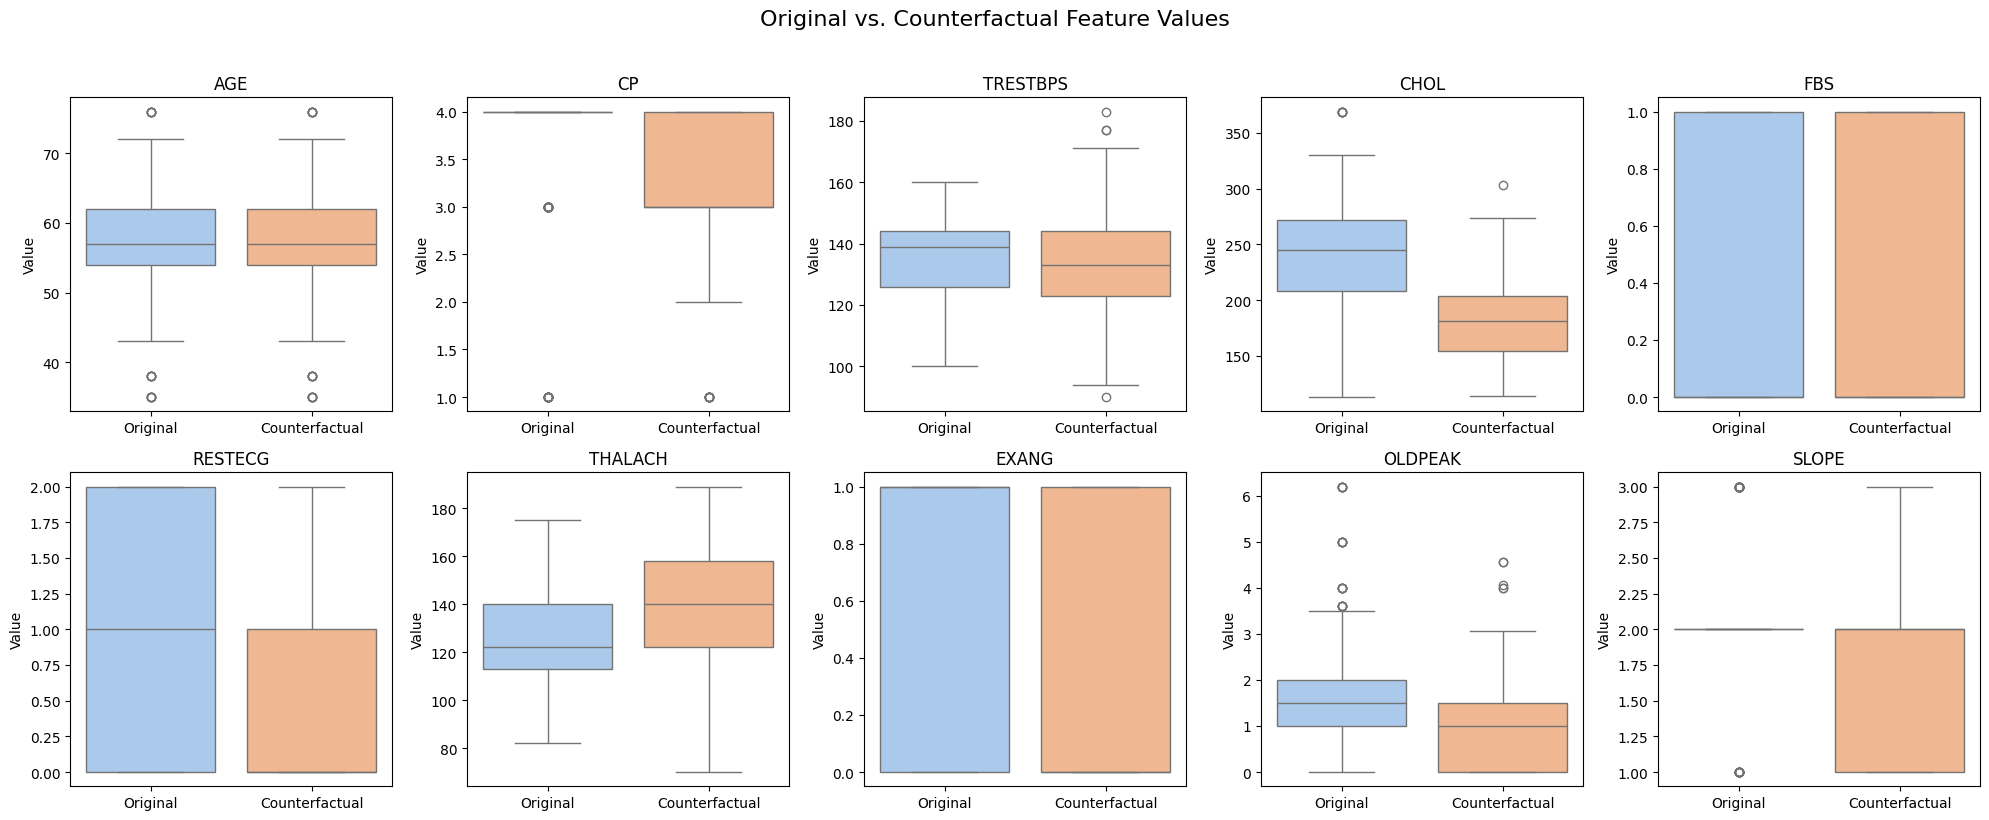

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of features to compare. (Including some immutable ones for completeness.)
features = ["age", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope"]

# Prepare a long-form DataFrame for plotting.
data_list = []
for feature in features:
    # For original values
    data_list.append(pd.DataFrame({
        "Feature": feature,
        "Type": "Original",
        "Value": df_scm[f"orig_{feature}"]
    }))
    # For counterfactual values
    data_list.append(pd.DataFrame({
        "Feature": feature,
        "Type": "Counterfactual",
        "Value": df_scm[f"cf_{feature}"]
    }))

df_long = pd.concat(data_list, ignore_index=True)

# Create subplots: one boxplot per feature.
n_features = len(features)
n_cols = 5  # number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharey=False)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.boxplot(
        x="Type", 
        y="Value", 
        hue="Type",  # Assign `Type` to `hue`
        data=df_long[df_long["Feature"] == feature], 
        ax=ax, 
        palette="pastel",  # Changed to pastel blue colors
        dodge=False,  # Prevents splitting by hue
        legend=False  # Suppress legend
    )
    ax.set_title(f"{feature.upper()}")
    ax.set_xlabel("")
    ax.set_ylabel("Value")
    
# If there are any empty subplots, hide them
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Original vs. Counterfactual Feature Values", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
import numpy as np

# Load the dataset
#df_scm = pd.read_csv("/mnt/data/all_counterfactuals_with_distances.csv")

# Filter for successful counterfactuals where target flipped (target_changed == 1)
df_success = df_scm[df_scm["target_changed"] == 1]

print("Total Successful Counterfactuals:", len(df_success))

# -------------------------------
# 1. Chest Pain Type (cp)
# -------------------------------
# Calculate how many successful CFs showed a change in chest pain type
cp_changed = (df_success["cf_cp"] != df_success["orig_cp"]).sum()
percent_cp_changed = cp_changed / len(df_success) * 100

print("\nChest Pain Type (cp):")
print(f" - {cp_changed} out of {len(df_success)} successful CFs changed cp ({percent_cp_changed:.1f}%).")

# Show frequency of original vs. CF cp values
cp_freq = pd.crosstab(df_success["orig_cp"], df_success["cf_cp"], rownames=["Orig_cp"], colnames=["CF_cp"])
print("\nChest Pain Frequency Table (Orig vs CF):")
print(cp_freq)

# -------------------------------
# 2. Exercise-Induced Angina (exang)
# -------------------------------
# Identify cases where exang changed from 1 to 0 and 0 to 1
exang_1_to_0 = ((df_success["orig_exang"] == 1) & (df_success["cf_exang"] == 0)).sum()
exang_0_to_1 = ((df_success["orig_exang"] == 0) & (df_success["cf_exang"] == 1)).sum()
percent_exang_1_to_0 = exang_1_to_0 / len(df_success) * 100
percent_exang_0_to_1 = exang_0_to_1 / len(df_success) * 100

print("\nExercise-Induced Angina (exang):")
print(f" - {exang_1_to_0} CFs ({percent_exang_1_to_0:.1f}%) changed from 1 to 0 (resolved angina).")
print(f" - {exang_0_to_1} CFs ({percent_exang_0_to_1:.1f}%) changed from 0 to 1.")

# -------------------------------
# 3. ST Depression (oldpeak)
# -------------------------------
# Calculate percent with reduced oldpeak in CF (i.e., cf_oldpeak < orig_oldpeak)
oldpeak_improved = (df_success["cf_oldpeak"] < df_success["orig_oldpeak"]).sum()
percent_oldpeak_improved = oldpeak_improved / len(df_success) * 100

# Compute mean oldpeak in diseased vs. healthy CFs and the mean difference
mean_orig_oldpeak = df_success["orig_oldpeak"].mean()
mean_cf_oldpeak = df_success["cf_oldpeak"].mean()
mean_diff_oldpeak = mean_cf_oldpeak - mean_orig_oldpeak

print("\nST Depression (oldpeak):")
print(f" - {oldpeak_improved} CFs ({percent_oldpeak_improved:.1f}%) had reduced oldpeak.")
print(f" - Mean oldpeak: Orig = {mean_orig_oldpeak:.2f} mm, CF = {mean_cf_oldpeak:.2f} mm.")
print(f" - Mean change: {mean_diff_oldpeak:.2f} mm (negative means improvement).")

# -------------------------------
# 4. Maximum Heart Rate (thalach)
# -------------------------------
# Calculate percent with increased thalach (cf_thalach > orig_thalach)
thalach_improved = (df_success["cf_thalach"] > df_success["orig_thalach"]).sum()
percent_thalach_improved = thalach_improved / len(df_success) * 100

# Compute mean thalach in diseased vs. healthy CFs and the mean change
mean_orig_thalach = df_success["orig_thalach"].mean()
mean_cf_thalach = df_success["cf_thalach"].mean()
mean_diff_thalach = mean_cf_thalach - mean_orig_thalach

print("\nMaximum Heart Rate (thalach):")
print(f" - {thalach_improved} CFs ({percent_thalach_improved:.1f}%) had increased thalach.")
print(f" - Mean thalach: Orig = {mean_orig_thalach:.1f} bpm, CF = {mean_cf_thalach:.1f} bpm.")
print(f" - Mean change: {mean_diff_thalach:.1f} bpm (positive means improvement).")

# -------------------------------
# 5. ST Slope (slope)
# -------------------------------
# Calculate percent with decreased slope (cf_slope < orig_slope) indicating improvement
slope_improved = (df_success["cf_slope"] < df_success["orig_slope"]).sum()
percent_slope_improved = slope_improved / len(df_success) * 100

print("\nST Slope (slope):")
print(f" - {slope_improved} CFs ({percent_slope_improved:.1f}%) had a decreased slope value (improved).")

# -------------------------------
# 6. Resting ECG (restecg)
# -------------------------------
# Calculate change in restecg: compute difference cf_restecg - orig_restecg
df_success["restecg_diff"] = df_success["cf_restecg"] - df_success["orig_restecg"]

# Count frequency of no change, improvement (negative diff), and worsening (positive diff)
restecg_no_change = (df_success["restecg_diff"] == 0).sum()
restecg_improved = (df_success["restecg_diff"] < 0).sum()
restecg_worsened = (df_success["restecg_diff"] > 0).sum()
percent_no_change = restecg_no_change / len(df_success) * 100
percent_improved = restecg_improved / len(df_success) * 100
percent_worsened = restecg_worsened / len(df_success) * 100

print("\nResting ECG (restecg):")
print(f" - {restecg_no_change} CFs ({percent_no_change:.1f}%) had no change.")
print(f" - {restecg_improved} CFs ({percent_improved:.1f}%) improved (restecg decreased).")
print(f" - {restecg_worsened} CFs ({percent_worsened:.1f}%) worsened (restecg increased).")

# -------------------------------
# Summary: Downstream Diagnostic Feature Changes
# -------------------------------
summary = {
    "cp_change_%": percent_cp_changed,
    "exang_1_to_0_%": percent_exang_1_to_0,
    "exang_0_to_1_%": percent_exang_0_to_1,
    "oldpeak_improved_%": percent_oldpeak_improved,
    "mean_orig_oldpeak": mean_orig_oldpeak,
    "mean_cf_oldpeak": mean_cf_oldpeak,
    "mean_diff_oldpeak": mean_diff_oldpeak,
    "thalach_improved_%": percent_thalach_improved,
    "mean_orig_thalach": mean_orig_thalach,
    "mean_cf_thalach": mean_cf_thalach,
    "mean_diff_thalach": mean_diff_thalach,
    "slope_improved_%": percent_slope_improved,
    "restecg_no_change_%": percent_no_change,
    "restecg_improved_%": percent_improved,
    "restecg_worsened_%": percent_worsened
}

print("\n--- Summary of Downstream Diagnostic Changes (Successful CFs) ---")
for k, v in summary.items():
    print(f"{k}: {v:.1f}" if isinstance(v, float) else f"{k}: {v}")


Total Successful Counterfactuals: 94

Chest Pain Type (cp):
 - 79 out of 94 successful CFs changed cp (84.0%).

Chest Pain Frequency Table (Orig vs CF):
CF_cp    1.0  2.0  3.0  4.0
Orig_cp                    
1.0        1    0    4    2
3.0        0    3    1    0
4.0        3   25   42   13

Exercise-Induced Angina (exang):
 - 59 CFs (62.8%) changed from 1 to 0 (resolved angina).
 - 4 CFs (4.3%) changed from 0 to 1.

ST Depression (oldpeak):
 - 68 CFs (72.3%) had reduced oldpeak.
 - Mean oldpeak: Orig = 1.75 mm, CF = 0.28 mm.
 - Mean change: -1.47 mm (negative means improvement).

Maximum Heart Rate (thalach):
 - 66 CFs (70.2%) had increased thalach.
 - Mean thalach: Orig = 127.6 bpm, CF = 145.3 bpm.
 - Mean change: 17.7 bpm (positive means improvement).

ST Slope (slope):
 - 76 CFs (80.9%) had a decreased slope value (improved).

Resting ECG (restecg):
 - 41 CFs (43.6%) had no change.
 - 30 CFs (31.9%) improved (restecg decreased).
 - 23 CFs (24.5%) worsened (restecg increased).

---

C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_29292\2085451310.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_success["restecg_diff"] = df_success["cf_restecg"] - df_success["orig_restecg"]


In [5]:
import pandas as pd
import numpy as np

# Load the dataset
#df_scm = pd.read_csv("/mnt/data/all_counterfactuals_with_distances.csv")

# Filter for successful counterfactuals where target flipped (target_changed == 1)
df_no_success = df_scm[df_scm["target_changed"] == 0]

print("Total Successful Counterfactuals:", len(df_no_success))

# -------------------------------
# 1. Chest Pain Type (cp)
# -------------------------------
# Calculate how many successful CFs showed a change in chest pain type
cp_changed = (df_no_success["cf_cp"] != df_no_success["orig_cp"]).sum()
percent_cp_changed = cp_changed / len(df_no_success) * 100

print("\nChest Pain Type (cp):")
print(f" - {cp_changed} out of {len(df_no_success)} successful CFs changed cp ({percent_cp_changed:.1f}%).")

# Show frequency of original vs. CF cp values
cp_freq = pd.crosstab(df_no_success["orig_cp"], df_no_success["cf_cp"], rownames=["Orig_cp"], colnames=["CF_cp"])
print("\nChest Pain Frequency Table (Orig vs CF):")
print(cp_freq)

# -------------------------------
# 2. Exercise-Induced Angina (exang)
# -------------------------------
# Identify cases where exang changed from 1 to 0 and 0 to 1
exang_1_to_0 = ((df_no_success["orig_exang"] == 1) & (df_no_success["cf_exang"] == 0)).sum()
exang_0_to_1 = ((df_no_success["orig_exang"] == 0) & (df_no_success["cf_exang"] == 1)).sum()
percent_exang_1_to_0 = exang_1_to_0 / len(df_no_success) * 100
percent_exang_0_to_1 = exang_0_to_1 / len(df_no_success) * 100

print("\nExercise-Induced Angina (exang):")
print(f" - {exang_1_to_0} CFs ({percent_exang_1_to_0:.1f}%) changed from 1 to 0 (resolved angina).")
print(f" - {exang_0_to_1} CFs ({percent_exang_0_to_1:.1f}%) changed from 0 to 1.")

# -------------------------------
# 3. ST Depression (oldpeak)
# -------------------------------
# Calculate percent with reduced oldpeak in CF (i.e., cf_oldpeak < orig_oldpeak)
oldpeak_improved = (df_no_success["cf_oldpeak"] < df_no_success["orig_oldpeak"]).sum()
percent_oldpeak_improved = oldpeak_improved / len(df_no_success) * 100

# Compute mean oldpeak in diseased vs. healthy CFs and the mean difference
mean_orig_oldpeak = df_no_success["orig_oldpeak"].mean()
mean_cf_oldpeak = df_no_success["cf_oldpeak"].mean()
mean_diff_oldpeak = mean_cf_oldpeak - mean_orig_oldpeak

print("\nST Depression (oldpeak):")
print(f" - {oldpeak_improved} CFs ({percent_oldpeak_improved:.1f}%) had reduced oldpeak.")
print(f" - Mean oldpeak: Orig = {mean_orig_oldpeak:.2f} mm, CF = {mean_cf_oldpeak:.2f} mm.")
print(f" - Mean change: {mean_diff_oldpeak:.2f} mm (negative means improvement).")

# -------------------------------
# 4. Maximum Heart Rate (thalach)
# -------------------------------
# Calculate percent with increased thalach (cf_thalach > orig_thalach)
thalach_improved = (df_no_success["cf_thalach"] > df_no_success["orig_thalach"]).sum()
percent_thalach_improved = thalach_improved / len(df_no_success) * 100

# Compute mean thalach in diseased vs. healthy CFs and the mean change
mean_orig_thalach = df_no_success["orig_thalach"].mean()
mean_cf_thalach = df_no_success["cf_thalach"].mean()
mean_diff_thalach = mean_cf_thalach - mean_orig_thalach

print("\nMaximum Heart Rate (thalach):")
print(f" - {thalach_improved} CFs ({percent_thalach_improved:.1f}%) had increased thalach.")
print(f" - Mean thalach: Orig = {mean_orig_thalach:.1f} bpm, CF = {mean_cf_thalach:.1f} bpm.")
print(f" - Mean change: {mean_diff_thalach:.1f} bpm (positive means improvement).")

# -------------------------------
# 5. ST Slope (slope)
# -------------------------------
# Calculate percent with decreased slope (cf_slope < orig_slope) indicating improvement
slope_improved = (df_no_success["cf_slope"] < df_no_success["orig_slope"]).sum()
percent_slope_improved = slope_improved / len(df_no_success) * 100

print("\nST Slope (slope):")
print(f" - {slope_improved} CFs ({percent_slope_improved:.1f}%) had a decreased slope value (improved).")

# -------------------------------
# 6. Resting ECG (restecg)
# -------------------------------
# Calculate change in restecg: compute difference cf_restecg - orig_restecg
df_no_success["restecg_diff"] = df_no_success["cf_restecg"] - df_no_success["orig_restecg"]

# Count frequency of no change, improvement (negative diff), and worsening (positive diff)
restecg_no_change = (df_no_success["restecg_diff"] == 0).sum()
restecg_improved = (df_no_success["restecg_diff"] < 0).sum()
restecg_worsened = (df_no_success["restecg_diff"] > 0).sum()
percent_no_change = restecg_no_change / len(df_no_success) * 100
percent_improved = restecg_improved / len(df_no_success) * 100
percent_worsened = restecg_worsened / len(df_no_success) * 100

print("\nResting ECG (restecg):")
print(f" - {restecg_no_change} CFs ({percent_no_change:.1f}%) had no change.")
print(f" - {restecg_improved} CFs ({percent_improved:.1f}%) improved (restecg decreased).")
print(f" - {restecg_worsened} CFs ({percent_worsened:.1f}%) worsened (restecg increased).")

# -------------------------------
# Summary: Downstream Diagnostic Feature Changes
# -------------------------------
summary = {
    "cp_change_%": percent_cp_changed,
    "exang_1_to_0_%": percent_exang_1_to_0,
    "exang_0_to_1_%": percent_exang_0_to_1,
    "oldpeak_improved_%": percent_oldpeak_improved,
    "mean_orig_oldpeak": mean_orig_oldpeak,
    "mean_cf_oldpeak": mean_cf_oldpeak,
    "mean_diff_oldpeak": mean_diff_oldpeak,
    "thalach_improved_%": percent_thalach_improved,
    "mean_orig_thalach": mean_orig_thalach,
    "mean_cf_thalach": mean_cf_thalach,
    "mean_diff_thalach": mean_diff_thalach,
    "slope_improved_%": percent_slope_improved,
    "restecg_no_change_%": percent_no_change,
    "restecg_improved_%": percent_improved,
    "restecg_worsened_%": percent_worsened
}

print("\n--- Summary of Downstream Diagnostic Changes (Successful CFs) ---")
for k, v in summary.items():
    print(f"{k}: {v:.1f}" if isinstance(v, float) else f"{k}: {v}")


Total Successful Counterfactuals: 143

Chest Pain Type (cp):
 - 67 out of 143 successful CFs changed cp (46.9%).

Chest Pain Frequency Table (Orig vs CF):
CF_cp    1.0  2.0  3.0  4.0
Orig_cp                    
1.0        0    1    2    5
3.0        3    3    2   13
4.0        2    6   32   74

Exercise-Induced Angina (exang):
 - 24 CFs (16.8%) changed from 1 to 0 (resolved angina).
 - 27 CFs (18.9%) changed from 0 to 1.

ST Depression (oldpeak):
 - 79 CFs (55.2%) had reduced oldpeak.
 - Mean oldpeak: Orig = 1.61 mm, CF = 1.38 mm.
 - Mean change: -0.22 mm (negative means improvement).

Maximum Heart Rate (thalach):
 - 87 CFs (60.8%) had increased thalach.
 - Mean thalach: Orig = 125.7 bpm, CF = 134.2 bpm.
 - Mean change: 8.5 bpm (positive means improvement).

ST Slope (slope):
 - 34 CFs (23.8%) had a decreased slope value (improved).

Resting ECG (restecg):
 - 45 CFs (31.5%) had no change.
 - 66 CFs (46.2%) improved (restecg decreased).
 - 32 CFs (22.4%) worsened (restecg increased).



C:\Users\praskulkarni\AppData\Local\Temp\ipykernel_29292\774975296.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_success["restecg_diff"] = df_no_success["cf_restecg"] - df_no_success["orig_restecg"]


For every unit change in cholesterol, resting BP changes by -0.04 units on average.


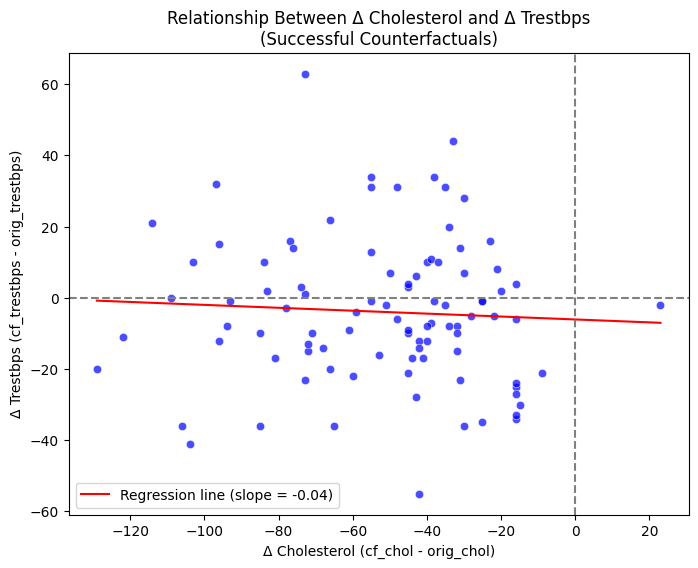

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate differences for cholesterol and resting blood pressure
df_scm["delta_chol"] = df_scm["cf_chol"] - df_scm["orig_chol"]
df_scm["delta_trestbps"] = df_scm["cf_trestbps"] - df_scm["orig_trestbps"]

# Filter for successful counterfactuals (where target_changed == 1)
df_success = df_scm[df_scm["target_changed"] == 1]

# Perform linear regression using numpy.polyfit to determine the slope
slope, intercept = np.polyfit(df_success["delta_chol"], df_success["delta_trestbps"], 1)
print(f"For every unit change in cholesterol, resting BP changes by {slope:.2f} units on average.")

# Plot the scatter plot with the regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x="delta_chol", y="delta_trestbps", data=df_success, color="blue", alpha=0.7)
x_vals = np.linspace(df_success["delta_chol"].min(), df_success["delta_chol"].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color="red", label=f"Regression line (slope = {slope:.2f})")
plt.title("Relationship Between Δ Cholesterol and Δ Trestbps\n(Successful Counterfactuals)")
plt.xlabel("Δ Cholesterol (cf_chol - orig_chol)")
plt.ylabel("Δ Trestbps (cf_trestbps - orig_trestbps)")
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="grey", linestyle="--")
plt.legend()
plt.show()
